# 3D pose extraction from 2D orthographic projection with DRaM

In this notebook we will demonstrate how to use the determinant ratio matrix (DRaM) to determine the pose of a 3D point cloud from its 2D orthographic projection.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from AdjQuat import utils
from AdjQuat import simulators
from AdjQuat import solutions

## 1. Data generation

First we will set up our data generation process.

In [4]:
# We define a manual seed for reproducilibity.
torch.manual_seed(0)

In [5]:
# First we generate random points in 3D space
npts = 50
xyz = torch.randn(npts, 3, dtype=torch.double)

In [6]:
xyz[0] # just to check our first point is the same for different runs

tensor([-2.3104, -0.3733, -1.0608], dtype=torch.float64)

We rotate this using the standard rotation matrix in terms of our quaternion ($\vec{q}=[q_0,q_1,q_2,q_3]$):

$$ {R}(\vec{q}) = \left[ \begin{array}{cc}  q_0^2 + q_1^2 - q_2^2 - q_3^2 & 2q_1q_2 - 2q_0q_3 & 2q_1q_3 + 2q_0q_2 \\ 2q_1q_2 + 2q_0q_3 & q_0^2 - q_1^2 + q_2^2 - q_3^2 & 2q_2q_3 - 2q_0q_1 \\ 2q_1q_3 - 2q_0q_2 & 2q_2q_3 + 2q_0q_1 &  q_0^2 - q_1^2 - q_2^2 + q_3^2 \end{array} \right]
$$

We will rotate this set of initial points by a small rotation to confirm our functions work as expected.

In [7]:
quaternion_small = np.array([np.cos(0.1),(1/np.sqrt(3))*np.sin(0.1),(1/np.sqrt(3))*np.sin(0.1),(1/np.sqrt(3))*np.sin(0.1)])

In [8]:
#convert to a rotation matrix and dot with our point cloud
rotation_small = utils.quat_to_rot(quaternion_small)
small_rot_xyz = rotation_small.dot(np.asarray(xyz).T).T

In [9]:
#convert to a projection matrix and dot with our point cloud
proj_small = utils.quat_to_proj(quaternion_small)
small_proj_xyz = proj_small.dot(np.asarray(xyz).T).T

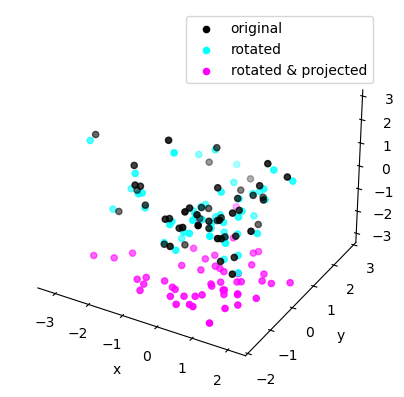

In [10]:
fig = plt.figure();
ax = plt.axes(projection='3d');
ax.scatter3D(xyz[:,0],xyz[:,1],xyz[:,2],color='black',label='original');
ax.scatter3D(small_rot_xyz[:,0],small_rot_xyz[:,1],small_rot_xyz[:,2],color='cyan',label='rotated');
ax.scatter3D(small_proj_xyz[:,0],small_proj_xyz[:,1],np.zeros(len(small_proj_xyz.T[0]))-3,color='magenta',label='rotated & projected');
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

The function we will actually use to generate data also includes added error:

In [11]:
sigma = 0.1
UV, xyz_error = utils.make_U3(xyz,quaternion_small,sigma)

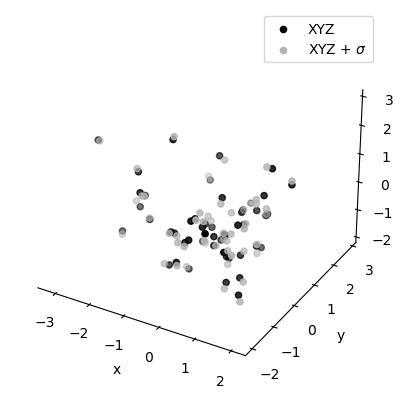

In [12]:
fig = plt.figure();
ax = plt.axes(projection='3d');
ax.scatter3D(xyz[:,0],xyz[:,1],xyz[:,2],color='black',label='XYZ');
ax.scatter3D(xyz_error[:,0],xyz_error[:,1],xyz_error[:,2],color='0.7',label='XYZ + $\sigma$');
#ax.scatter3D(UV[:,0],U[:,1],np.zeros(len(U.T[0]))-3,color='magenta',label='UV = (X + $\sigma$) $\cdot$ P');
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

### 2. Now let's evaluate our DRaM solution for this dataset.

Now we want to test equation (XX), which only gives a rotation matrix in the no noise case:

%% Derived  near bottom of. Pose-3D-working-1.nb WWW  - now reduce to determinants:
%%. detRulePose3D and revDetRulePose3D. and VVV do Rot3 cross-product det6, 9, 10
%%. TABLE of the remaining determinants in Pose-3D2D-Summary.nb. "DET TABLE"

$$
\tilde{R}(x,y,z;u,v)  = \left[ \begin{array}{ccc}
 \displaystyle\frac{d_{7}}{d_{1}} &     
              -\displaystyle\frac{d_{4}}{d_{1}} & 
                        \displaystyle\frac{d_{2}}{d_{1}}\\[0.15in]
 \displaystyle\frac{d_{8}}{d_{1}} &
    -\displaystyle\frac{d_{5}}{d_{1}} &
             \displaystyle\frac{d_{3}}{d_{1}}\\[0.15in]
         \displaystyle\frac{d_{6}}{d_{1}} &
       \displaystyle\frac{d_{9}}{d_{1}} &
          \displaystyle\frac{d_{10}}{d_{1}}\\ 
          \end{array} \right]
$$

where
$$\begin{equation}
\begin{aligned}
   & \ \  d_{1}\to \left[
\begin{array}{ccc}
 \text{xx} & \text{xy} & \text{xz} \\
 \text{xy} & \text{yy} & \text{yz} \\
 \text{xz} & \text{yz} & \text{zz} \\
\end{array} \right]     \\ 
d_{2}\to \left[ \begin{array}{ccc}
 \text{xx} & \text{xy} & \text{ux} \\
 \text{xy} & \text{yy} & \text{uy} \\
 \text{xz} & \text{yz} & \text{uz} \\
\end{array} \right] &  \ \ 
d_{3} \to \left[ \begin{array}{ccc}
 \text{xx} & \text{xy} & \text{vx} \\
 \text{xy} & \text{yy} & \text{vy} \\
 \text{xz} & \text{yz} & \text{vz} \\
\end{array} \right] &    
d_{4}\to \left[ \begin{array}{ccc}
 \text{xx} & \text{xz} & \text{ux} \\
 \text{xy} & \text{yz} & \text{uy} \\
 \text{xz} & \text{zz} & \text{uz} \\
\end{array} \right] \ \ \   \\ 
d_{5}\to \left[ \begin{array}{ccc}
 \text{xx} & \text{xz} & \text{vx} \\
 \text{xy} & \text{yz} & \text{vy} \\
 \text{xz} & \text{zz} & \text{vz} \\
\end{array} \right] &  \ \ 
d_{6}\to \left[ \begin{array}{ccc}
 \text{xx} & \text{ux} & \text{vx} \\
 \text{xy} & \text{uy} & \text{vy} \\
 \text{xz} & \text{uz} & \text{vz} \\
\end{array} \right]      &
 d_{7} \to \left[ \begin{array}{ccc}
 \text{xy} & \text{xz} & \text{ux} \\
 \text{yy} & \text{yz} & \text{uy} \\
 \text{yz} & \text{zz} & \text{uz} \\
\end{array} \right] \ \ \  \\ 
 d_{8} \to \left[ \begin{array}{ccc}
 \text{xy} & \text{xz} & \text{vx} \\
 \text{yy} & \text{yz} & \text{vy} \\
 \text{yz} & \text{zz} & \text{vz} \\
\end{array} \right] & \ \
d_{9}\to \left[ \begin{array}{ccc}
 \text{xy} & \text{ux} & \text{vx} \\
 \text{yy} & \text{uy} & \text{vy} \\
 \text{yz} & \text{uz} & \text{vz} \\
\end{array} \right]  
&   d_{10}\to \left[  \begin{array}{ccc}
 \text{xz} & \text{ux} & \text{vx} \\
 \text{yz} & \text{uy} & \text{vy} \\
 \text{zz} & \text{uz} & \text{vz} \\
\end{array} \right] .    \\
    \end{aligned}
  \end{equation}$$

In [13]:
DRaM = solutions.make_R_tilde(xyz,UV)
DRaM

array([[ 1.00578639, -0.11702705,  0.11740782],
       [ 0.10369228,  0.98431601, -0.10701757],
       [-0.10304245,  0.1198111 ,  1.00214644]])

In [14]:
#How close are we?
rotation_small

array([[ 0.98671105, -0.10805732,  0.12134627],
       [ 0.12134627,  0.98671105, -0.10805732],
       [-0.10805732,  0.12134627,  0.98671105]])

Looks close, but let's use least squares to evaluate our loss quantitatively.

In [15]:
rot_mat_lsq = utils.least_squares_4_3D(rotation_small,xyz,UV)
rot_mat_lsq

np.float64(0.9857339142993576)

In [16]:
DRaM_lsq = utils.least_squares_4_3D(DRaM,xyz,UV)
DRaM_lsq

np.float64(0.9406355641210123)

Because of the noise, the DRaM can actually produce a better solution than the original rotation we used to generate UV!

In [17]:
#Just to check the no noise case:
UV_no_error, xyz_error_no_error = utils.make_U3(xyz,quaternion_small,0.0)
DRaM_no_error = solutions.make_R_tilde(xyz,UV_no_error)

In [18]:
utils.least_squares_4_3D(rotation_small,xyz,UV_no_error)

np.float64(6.917940360238951e-31)

In [19]:
utils.least_squares_4_3D(DRaM_no_error,xyz,UV_no_error)

np.float64(5.391542476328971e-29)

However (also because of the noise), this DRaM solution is not actually an orthogonal rotation matrix, so we need to correct using the Bar-Itzhack formalism.

In [20]:
R_BI = solutions.make_M_opt_rot(xyz,UV)
R_BI # or DRaM_corrected

array([[ 0.98807491, -0.10352848,  0.11397288],
       [ 0.11572451,  0.98759069, -0.1061719 ],
       [-0.10156674,  0.11809524,  0.98779437]])

In [21]:
#How close are we?
rotation_small

array([[ 0.98671105, -0.10805732,  0.12134627],
       [ 0.12134627,  0.98671105, -0.10805732],
       [-0.10805732,  0.12134627,  0.98671105]])

In [22]:
DRaM_corr_lsq = utils.least_squares_4_3D(R_BI,xyz,UV)
DRaM_corr_lsq

np.float64(0.9778818753768211)

This loss is higher than for the original DRaM, but it is a valid rotation matrix, and it is still lower than the original rotation used to generate the noisey data!

## 3. Compare to argmin result.

In [23]:
xyz = np.asarray(xyz)
U = UV

In [24]:
quat_argmin = utils.argmin_f(xyz, U)
quat_argmin

array([0.99546922, 0.05563179, 0.05474277, 0.05430806])

In [25]:
quaternion_small

array([0.99500417, 0.05763885, 0.05763885, 0.05763885])

In [26]:
rotation_argmin = utils.quat_to_rot(quat_argmin)

In [27]:
argmin_lsq = utils.least_squares_4_3D(rotation_argmin,xyz,UV)
argmin_lsq

np.float64(0.9775127108525088)

3.1 Compare to Procrustes-Wasserstein

In [ ]:
from AdjQuat.procrustes_wasserstein import procrustes_wasserstein_2d_3d_dram, procrustes_wasserstein_2d_3d_svd

transport_plan_pwdram, rotation_pwdram, logs = procrustes_wasserstein_2d_3d_dram(torch.from_numpy(xyz), torch.from_numpy(U), verbose_log=True, cost_d=2, tol=1e-6, max_iter=10)
pwdram_lsq = utils.least_squares_4_3D(rotation_pwdram,transport_plan_pwdram @ xyz,UV)

In [91]:
transport_plan_pwsvd, rotation_pwsvd, logs = procrustes_wasserstein_2d_3d_svd(torch.from_numpy(U), torch.from_numpy(xyz), p=torch.ones(npts), q=torch.ones(npts), verbose_log=True, tol=-1, max_iter=3)
pwsvd_lsq = utils.least_squares_4_3D(rotation_pwsvd.numpy(), xyz,UV)
pwsvd_lsq

np.float64(25.3184653040878)

In [94]:
utils.least_squares_4_3D(np.eye(3), xyz,UV)

np.float64(3.760046243477982)

In [92]:
(transport_plan_pwsvd @ xyz @ rotation_pwsvd.numpy())[:,:2], UV

(array([[-2.26632499, -0.12739424],
        [ 0.81497239, -0.43864245],
        [-0.53575019, -0.25372946],
        [ 1.34624373, -0.13123087],
        [ 1.28130821, -0.97952135],
        [ 0.30352592,  0.46307248],
        [-1.16037704, -0.7849102 ],
        [ 0.1699538 ,  0.55793055],
        [ 1.01800567,  0.25734493],
        [-1.46694019, -1.47274415],
        [-0.33532885, -0.79955923],
        [ 0.52881062,  0.61002007],
        [-1.09223549, -1.66955093],
        [ 0.84004775,  0.62204254],
        [-1.37702596,  1.65689335],
        [ 0.41160813, -1.27331105],
        [-3.0720788 , -1.24708415],
        [-0.19063505, -1.20386604],
        [ 0.7299416 ,  1.32251692],
        [-2.05185792, -0.03063474],
        [-0.24970627,  0.63636641],
        [ 0.13135872, -0.95570141],
        [ 1.00427614, -0.03550896],
        [ 1.1836361 , -1.90090494],
        [ 1.07654374, -0.08307832],
        [ 1.95232621, -0.06598749],
        [-0.14459349,  1.62661257],
        [ 0.44064362, -0.911

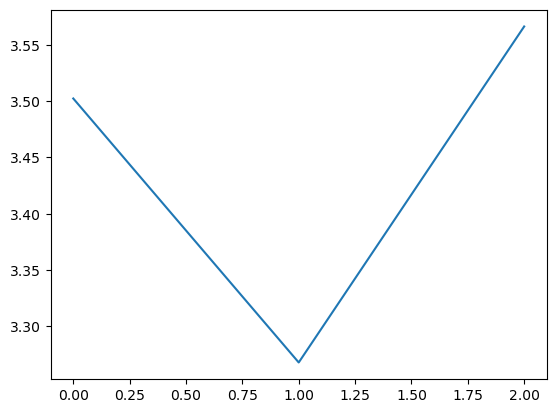

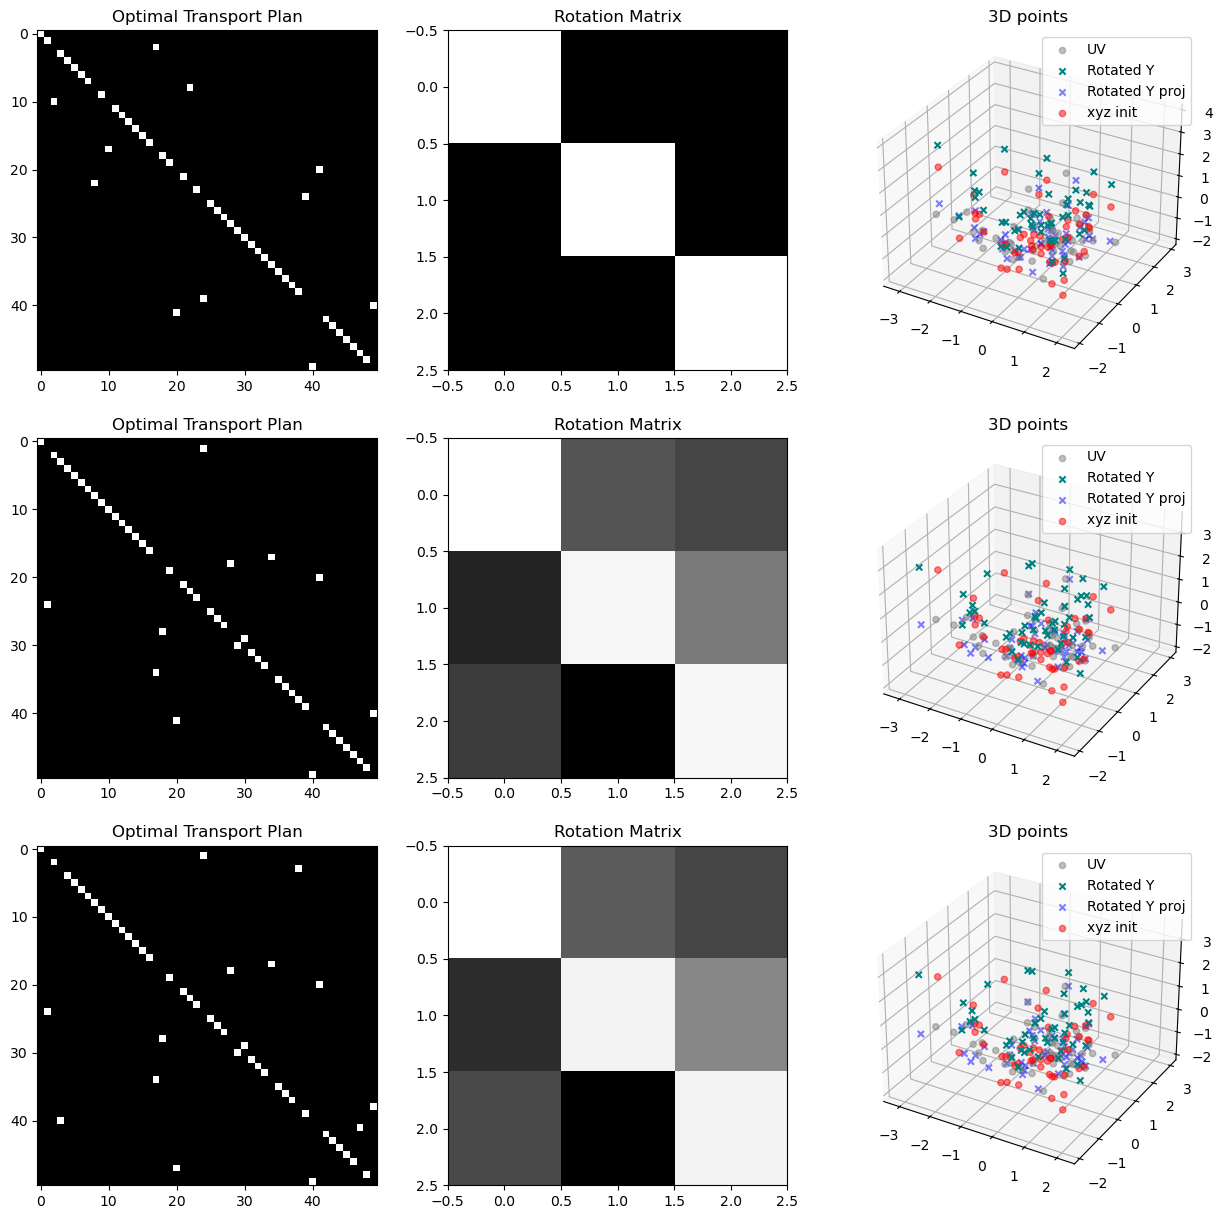

In [ ]:
n_pl = min(10, len(logs))
transport_plans = [log['transport_plan'] for log in logs[:n_pl]]
Ps = [log['R'] for log in logs[:n_pl]]
YR = [log['YR'] for log in logs[:n_pl]]

plt.plot([log['cost'] for log in logs], label='EMD')
plt.show()


# plot these three
fig, axes = plt.subplots(n_pl, 3, figsize=(15, 5*n_pl), )
for idx in range(len(transport_plans)):
    axes[idx, 0].imshow(transport_plans[idx], cmap='gray')
    axes[idx,0].set_title('Optimal Transport Plan')
    axes[idx,1].imshow(Ps[idx], cmap='gray')
    axes[idx,1].set_title('Rotation Matrix')

    axes[idx, 2].remove()

    ax2 = fig.add_subplot(n_pl, 3, 3 * idx + 3, projection='3d')
    alpha = 0.5
    ax2.scatter(xs=UV[:, 0], ys=UV[:, 1], zs=0, label='UV', marker='o', color='gray', alpha=alpha)
    ax2.scatter(xs=YR[idx][:, 0], ys=YR[idx][:, 1], zs=YR[idx][:, 2]+1, label='Rotated Y', marker='x', color='teal', alpha=1)
    ax2.scatter(xs=YR[idx][:, 0], ys=YR[idx][:, 1], zs=0, label='Rotated Y proj', marker='x', color='blue', alpha=alpha)
    ax2.scatter(xs=xyz[:, 0], ys=xyz[:, 1], zs=xyz[:, 2], label='xyz init', marker='o', color='red', alpha=alpha)
    ax2.set_title('3D points')
    ax2.legend()






In [87]:
#Let's plot these errors to compare
# %pylab inline
compare_errors = [rot_mat_lsq, DRaM_lsq, DRaM_corr_lsq, argmin_lsq, pwdram_lsq, pwsvd_lsq]

Text(0, 0.5, 'lsq')

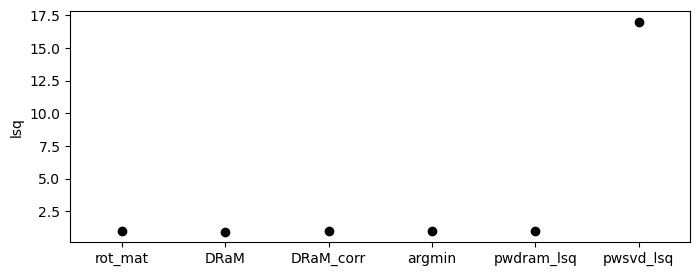

In [88]:
plt.figure(figsize=(8,3))
plt.plot([1,2,3,4,5,6],compare_errors ,'ko');
ticks = [1,2,3,4,5,6]
labels = ["rot_mat", "DRaM","DRaM_corr", "argmin", "pwdram_lsq", "pwsvd_lsq"]
plt.xticks(ticks, labels)
plt.xlim((0.5,6.5))
plt.ylabel('lsq')

In [31]:
#Just to check the no noise case for arg_min:
U = UV_no_error
quat_argmin_no_error = utils.argmin_f(xyz, U)
quat_argmin_no_error

array([0.99500405, 0.05764049, 0.05763953, 0.05763905])

In [32]:
rotation_argmin_no_error = utils.quat_to_rot(quat_argmin_no_error)

In [33]:
utils.least_squares_4_3D(rotation_argmin_no_error,xyz,UV_no_error)

np.float64(6.658912230097997e-10)

Back to the errorful case - let's plot the xyz points we get if we use the estimated rotations.

In [34]:
#Let's look at the result.
small_rot_error_xyz = rotation_small.dot(np.asarray(xyz_error).T).T
DRaM_xyz = DRaM.dot(xyz.T).T
DRaM_corr_xyz = R_BI.dot(xyz.T).T
argmin_xyz = rotation_argmin.dot(xyz.T).T

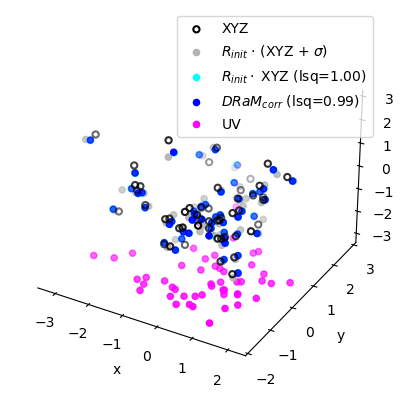

In [49]:
fig = plt.figure();
ax = plt.axes(projection='3d');
ax.scatter3D(xyz[:,0],xyz[:,1],xyz[:,2], facecolors='none', edgecolors='k',linewidths=1.5,label='XYZ');
ax.scatter3D(small_rot_error_xyz[:,0],small_rot_error_xyz[:,1],small_rot_error_xyz[:,2],color='0.7',label='$R_{init}$ $\cdot$ (XYZ + $\sigma$)');
ax.scatter3D(small_rot_xyz[:,0],small_rot_xyz[:,1],small_rot_xyz[:,2],color='cyan',label='$R_{init} \cdot$ XYZ (lsq=%.2f)'%rot_mat_lsq);
ax.scatter3D(DRaM_corr_xyz[:,0],DRaM_corr_xyz[:,1],DRaM_corr_xyz[:,2],color='blue',label='$DRaM_{corr}$ (lsq=%.2f)'%DRaM_corr_lsq);
#ax.scatter3D(argmin_xyz[:,0],argmin_xyz[:,1],argmin_xyz[:,2],color='red',label=r'$R_{argmin}$ (lsq=%.2f)'%argmin_lsq);

ax.scatter3D(small_proj_xyz[:,0],small_proj_xyz[:,1],np.zeros(len(small_proj_xyz.T[0]))-3,color='magenta',label='UV');
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

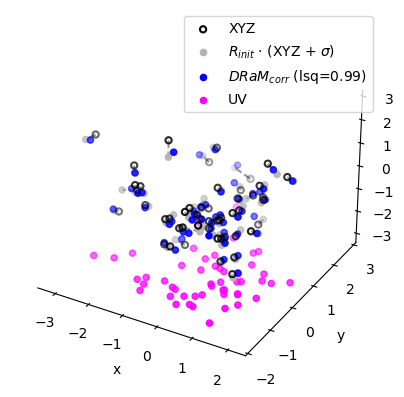

In [50]:
fig = plt.figure();
ax = plt.axes(projection='3d');
ax.scatter3D(xyz[:,0],xyz[:,1],xyz[:,2], facecolors='none', edgecolors='k',linewidths=1.5,label='XYZ');
ax.scatter3D(small_rot_error_xyz[:,0],small_rot_error_xyz[:,1],small_rot_error_xyz[:,2],color='0.7',label='$R_{init}$ $\cdot$ (XYZ + $\sigma$)');
#ax.scatter3D(small_rot_xyz[:,0],small_rot_xyz[:,1],small_rot_xyz[:,2],color='cyan',label='$R_{init} \cdot$ XYZ (lsq=%.2f)'%rot_mat_lsq);
ax.scatter3D(DRaM_corr_xyz[:,0],DRaM_corr_xyz[:,1],DRaM_corr_xyz[:,2],color='blue',label='$DRaM_{corr}$ (lsq=%.2f)'%DRaM_corr_lsq);
#ax.scatter3D(argmin_xyz[:,0],argmin_xyz[:,1],argmin_xyz[:,2],color='red',label=r'$R_{argmin}$ (lsq=%.2f)'%argmin_lsq);

for i in range(len(xyz[:,0])):
    ax.plot([xyz[i,0],small_rot_error_xyz[i,0]],[xyz[i,1],small_rot_error_xyz[i,1]],[xyz[i,2],small_rot_error_xyz[i,2]],color='black',linestyle='--',alpha=0.4);

ax.scatter3D(small_proj_xyz[:,0],small_proj_xyz[:,1],np.zeros(len(small_proj_xyz.T[0]))-3,color='magenta',label='UV');
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()
#still to do: draw chord

### 4. Testing DRaM_corrected with many replicates and various parameters.

In [37]:
R_set, xyz_set, U_set = simulators.generate_data_3D(100,50,0.1) #100 replicates, npts=50, sigma=0.1

In [38]:
Rt_estimated = [solutions.make_R_tilde(xyz, U) for xyz, U in zip(xyz_set, U_set)]
lsq = [utils.least_squares_4_3D(Rt_estimated[idx],xyz, U) for idx, (xyz, U) in enumerate(zip(xyz_set, U_set ))]
lsq_rot = [utils.least_squares_4_3D(R,xyz, U) for (R, xyz, U) in zip(R_set, xyz_set, U_set )]
Mq_estimated = [solutions.make_M_opt_rot(xyz,U) for xyz, U in zip(xyz_set, U_set)]
lsq_M = [utils.least_squares_4_3D(Mq_estimated[idx],xyz,U) for idx, (xyz, U) in enumerate(zip(xyz_set, U_set ))]

In [39]:
#sorting indices to make it more interprettable
lsq_M_sorted_indices = np.argsort(lsq_M)

In [40]:
lsq_M_sortedbyM = [lsq_M[i] for i in lsq_M_sorted_indices]
lsq_sortedbyM  = [lsq[i] for i in lsq_M_sorted_indices]
lsq_rot_sortedbyM  = [lsq_rot[i] for i in lsq_M_sorted_indices]

In [41]:
q_argmin = [utils.argmin_f(xyz, U) for xyz, U in zip(xyz_set, U_set)]
R_argmin = [utils.quat_to_rot(q) for q in q_argmin]
lsq_argmin = [utils.least_squares_4_3D(R_argmin[idx],xyz,U) for idx, (xyz, U) in enumerate(zip(xyz_set, U_set ))]


In [42]:
lsq_argmin_sortedbyM  = [lsq_argmin[i] for i in lsq_M_sorted_indices]

In [43]:
diff = [lsq_M[i]-lsq_argmin[i] for i in lsq_M_sorted_indices]
diff_20 = [20*(lsq_M[i]-lsq_argmin[i])+0.55 for i in lsq_M_sorted_indices]

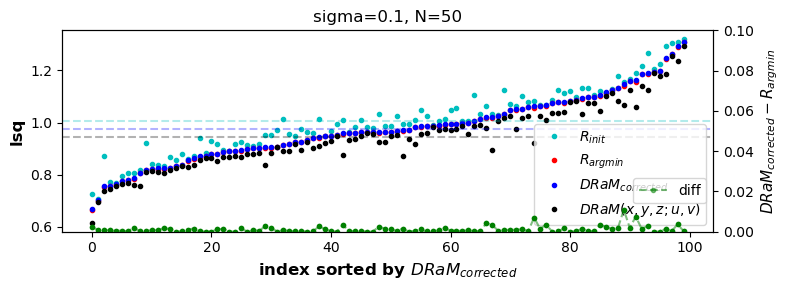

In [44]:
fig,ax = plt.subplots(figsize=[8,3])
plt.plot(lsq_rot_sortedbyM,'c.',label=r'$R_{init}$');
plt.plot(lsq_argmin_sortedbyM,'r.',label=r'$R_{argmin}$');
plt.plot(lsq_M_sortedbyM,'b.',label=r'$DRaM_{corrected}$');
plt.plot(lsq_sortedbyM,'k.',label=r'$DRaM(x,y,z;u,v)$');
plt.axhline(y=np.mean(lsq_M),linestyle='--',color='b',alpha=0.3)
plt.axhline(y=np.mean(lsq_rot),linestyle='--',color='c',alpha=0.3)
plt.axhline(y=np.mean(lsq),linestyle='--',color='k',alpha=0.3)
plt.legend()
plt.ylabel('lsq',fontsize=12,fontweight='bold')
plt.xlabel(r'index sorted by $DRaM_{corrected}$',fontsize=12,fontweight='bold')

ax2=ax.twinx()
ax2.plot(diff,'g.')
ax2.plot(diff,'g.',linestyle='--',alpha=0.5,label='diff')
plt.ylim((0,0.1))
plt.legend(bbox_to_anchor=(1, 0.3))
plt.ylabel(r'$DRaM_{corrected} - R_{argmin}$',fontsize=11,fontweight='bold')

plt.title('sigma=0.1, N=50');
plt.tight_layout();

plt.savefig('DRaM_orthographic.png',dpi=300)
#plt.savefig('DRaM_orthographic.eps',dpi=300)